In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('/content/drive/MyDrive/dtree/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dtree/test.csv')

In [4]:
# データの変換
##maleを0に、femaleを1に変換
train["Sex"] = train["Sex"].map({"male":0,"female":1})
test["Sex"] = test["Sex"].map({"male":0,"female":1})
# EmbarkedのOne-Hotエンコーディング
train = pd.get_dummies(train, columns=['Embarked'])
test = pd.get_dummies(test, columns=['Embarked'])

## 不要な列の削除
train.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [5]:
# NaN の存在確認 と 除去
print(train.isnull().sum())

train2 = train.dropna()
test2 = test.dropna()

Survived        0
Pclass          0
Sex             0
Age           177
SibSp           0
Parch           0
Fare            0
Embarked_C      0
Embarked_Q      0
Embarked_S      0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# devide train input and output
X_train = train2.drop(['Survived'], axis=1)  # X_trainはtrainのSurvived列以外
y_train = train2['Survived']  # y_trainはtrainのSurvived列

# X_trainとY_trainをtrainとvalidに分割
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.20, random_state=0)

In [7]:
import sklearn.tree as tree

# 分類木だからClassifier，Regressorもある
clf = tree.DecisionTreeClassifier(max_depth=4)

# データを用いて学習
model = clf.fit(train_x, train_y)

# データを用いて予測
predicted = model.predict(valid_x)
print(accuracy_score(predicted,valid_y))

0.7902097902097902


In [8]:
# 3分割交差検証を指定し、インスタンス化
from sklearn.model_selection import KFold
kf = KFold(n_splits=3, shuffle=True, random_state=0)

# スコアとモデルを格納するリスト
score_list = []
models = []

# 各分割ごとに評価
for fold_, (train_index, valid_index) in enumerate(kf.split(X_train, y_train)):    
    print(f'fold{fold_ + 1} start')
    train_x = X_train.iloc[train_index]
    valid_x = X_train.iloc[valid_index]
    train_y = y_train.iloc[train_index]
    valid_y = y_train.iloc[valid_index]
    
    ## 分割データで学習・予測・評価
    clf = tree.DecisionTreeClassifier(max_depth=4)
    model = clf.fit(train_x, train_y)
    
    # データを用いて予測，記録
    predicted = model.predict(valid_x)
    score_list.append(accuracy_score(predicted,valid_y))
    models.append(model)
print(score_list, '平均score', round(np.mean(score_list), 3))

fold1 start
fold2 start
fold3 start
[0.8067226890756303, 0.7647058823529411, 0.819327731092437] 平均score 0.797


In [9]:
from sklearn.metrics import confusion_matrix

#混同行列の作成
cmatrix = confusion_matrix(valid_y,predicted)

#pandasで表の形に
df = pd.DataFrame(cmatrix,index=["actual_died","actual_survived"],columns=["pred_died","pred_survived"])

print(df)

                 pred_died  pred_survived
actual_died            131             14
actual_survived         29             64


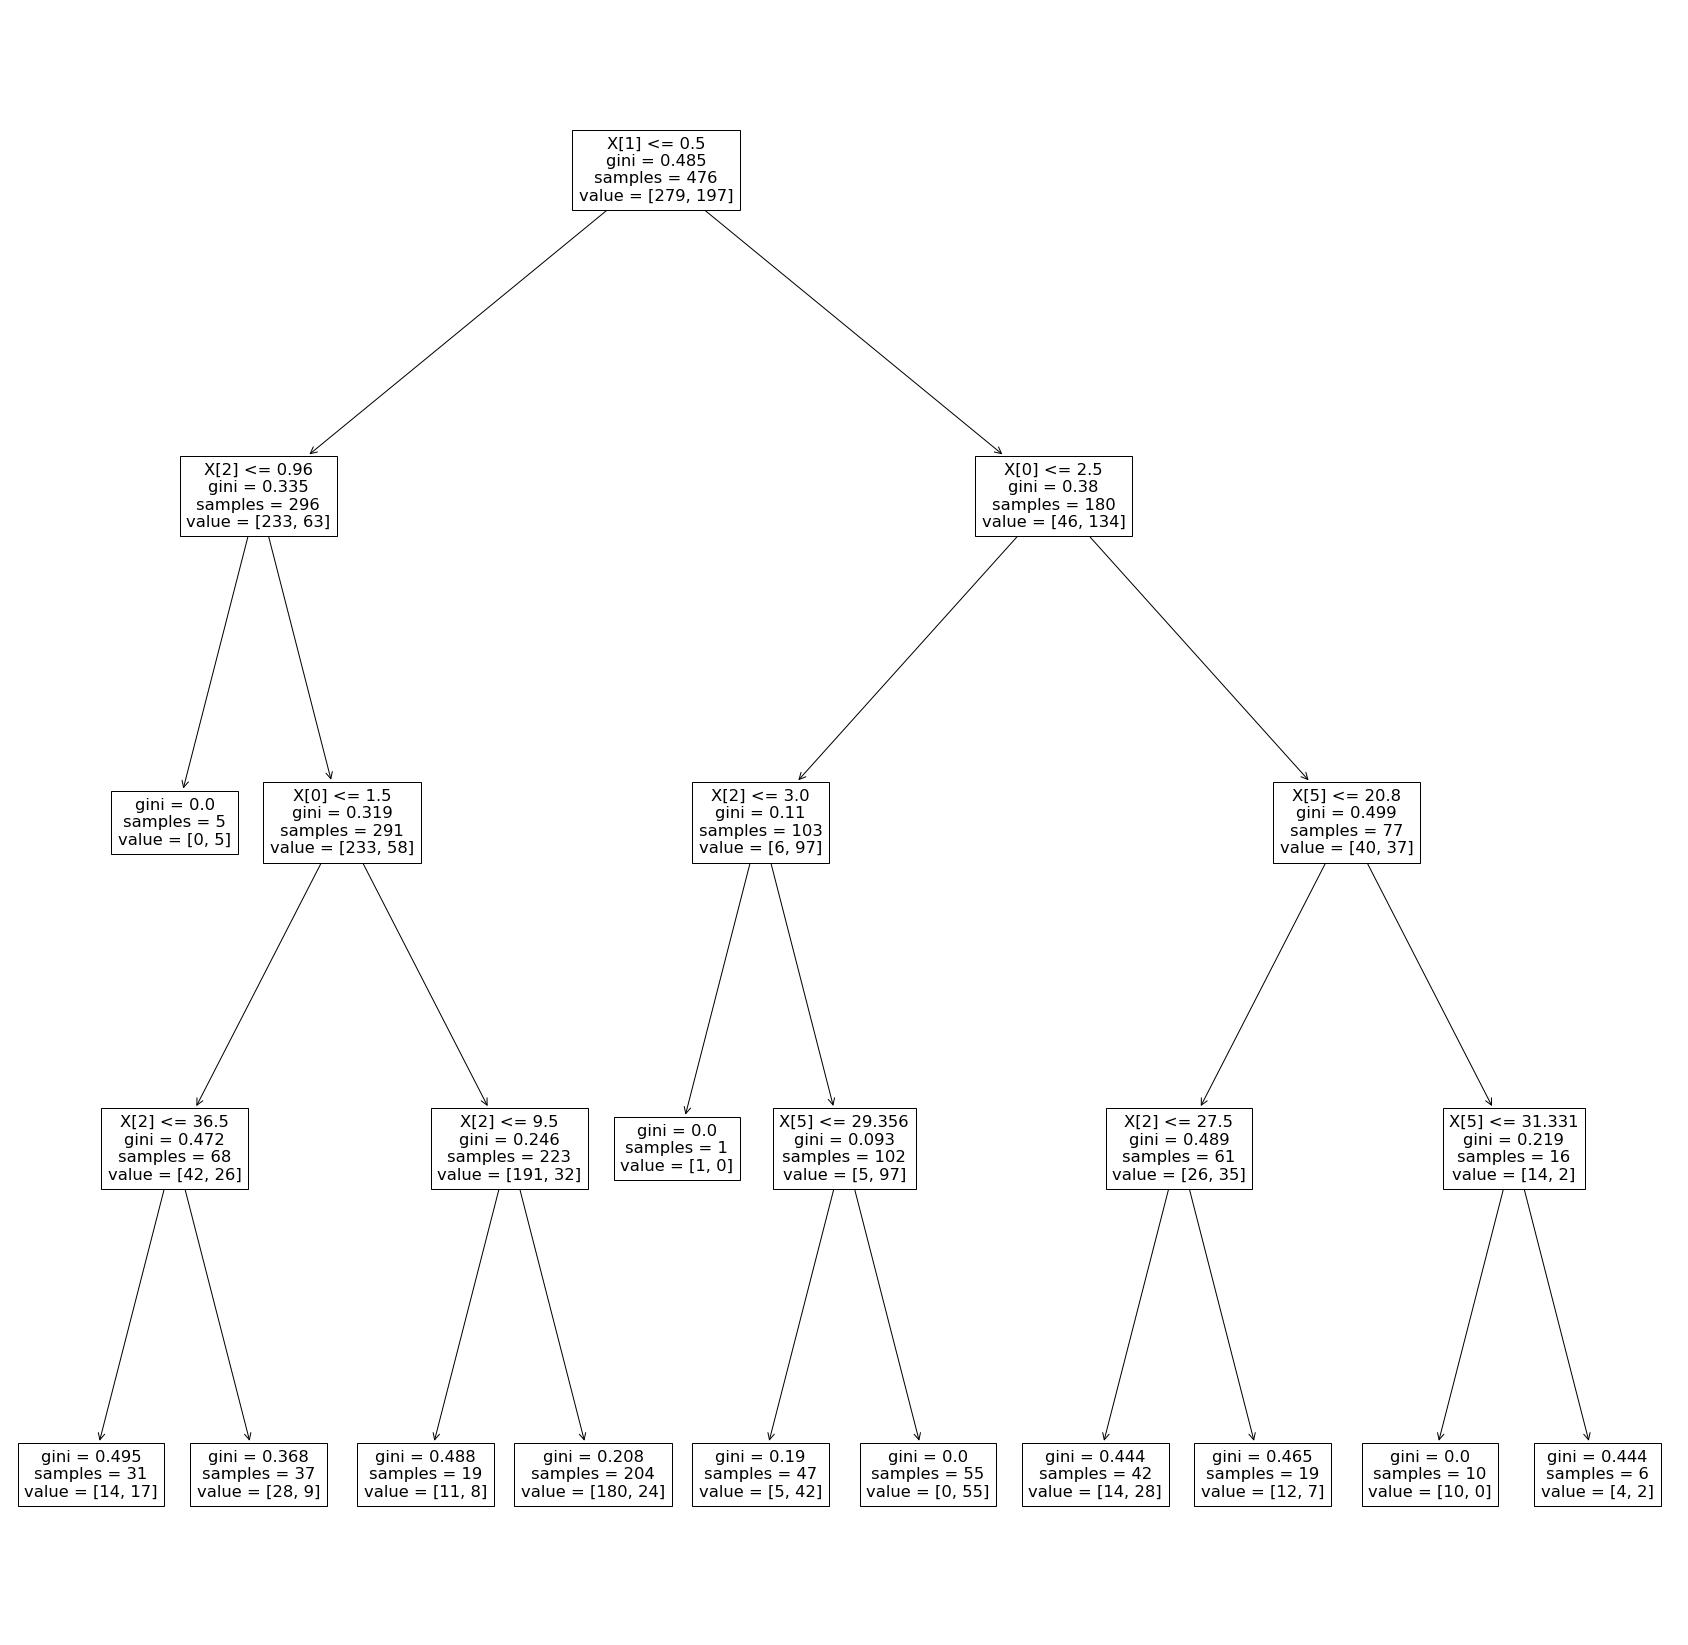

In [10]:
# 図示その１
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 30))  # whatever size you want
tree.plot_tree(model, ax=ax)
plt.show()

In [12]:
!pip install dtreeviz
# graphvizによる視覚化
import pydotplus as pdp

file_name = "/content/drive/MyDrive/dtree/tree_visualization.png"
dot_data = tree.export_graphviz(model, # 決定木オブジェクトを一つ指定する
                                out_file=None, # ファイルは介さずにGraphvizにdot言語データを渡すのでNone
                                filled=True, # Trueにすると、分岐の際にどちらのノードに多く分類されたのか色で示してくれる
                                rounded=True, # Trueにすると、ノードの角を丸く描画する。
                                feature_names=train_x.columns, # これを指定しないとチャート上で特徴量の名前が表示されない
                                class_names=['Dead','Sruvived'], # これを指定しないとチャート上で分類名が表示されない
                                special_characters=True # 特殊文字を扱えるようにする
                                )
graph = pdp.graph_from_dot_data(dot_data)
graph.write_png(file_name)

# dtreevizによる視覚化
from dtreeviz.trees import dtreeviz

viz = dtreeviz(
    model,
    train_x, 
    train_y,
    target_name='alive',
    feature_names=train_x.columns,
    class_names=['Dead','Sruvived']
) 

#viz.view() # 外窓で画像を開く
viz.save('/content/drive/MyDrive/dtree/dtreeviz.svg')

     |████████████████████████████████| 62 kB 665 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3.2-py3-none-any.whl size=67936 sha256=8ea006e549e5f0461ae8b99db2684c98aef490938e459bea863f2730fa49a031
  Stored in directory: /root/.cache/pip/wheels/9d/29/a1/f2ad20de79875e749330d5c6234fc5f517991fcaa23d7a3d0f
Successfully built dtreeviz


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


{'Pclass': 0.22198751305914832, 'Sex': 0.5687679329042562, 'Age': 0.15069654009838473, 'SibSp': 0.0, 'Parch': 0.0, 'Fare': 0.058548013938210734, 'Embarked_C': 0.0, 'Embarked_Q': 0.0, 'Embarked_S': 0.0}


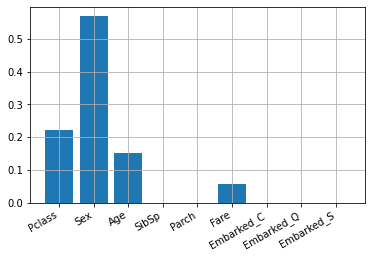

In [13]:
# 重要度を表示
print(dict(zip(train_x.columns, model.feature_importances_)))

# bar plot
fig, ax = plt.subplots()
plt.grid()
ax.bar(train_x.columns,model.feature_importances_)
fig.autofmt_xdate() # make space for and rotate the x-axis tick labels
plt.show()